In [ ]:
#PPO with Known Completion rewards

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# === PPO Hyperparameters ===
alpha = 0.01     # Learning rate
eps_clip = 0.2   # Clipping epsilon
epochs = 500     # Training steps

# === Completions and Rewards ===
completions = ["cream", "hockey", "donkey"]
completion_rewards = {"cream": 10, "hockey": 5, "donkey": -10}
vocab_size = len(completions)

# === Simple PPO Model ===
class PPOModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.policy = nn.Linear(1, vocab_size)  # Dummy input
        self.value = nn.Linear(1, 1)

    def forward(self, x):
        logits = self.policy(x)
        probs = torch.softmax(logits, dim=-1)
        value = self.value(x)
        return probs, value

model = PPOModel(vocab_size)
optimizer = optim.Adam(model.parameters(), lr=alpha)

# === Training Loop ===
for epoch in range(epochs):
    # Dummy state (since prompt is fixed)
    state = torch.tensor([[1.0]])

    # Forward pass
    probs, value = model(state)
    dist = torch.distributions.Categorical(probs)
    action = dist.sample()
    logprob = dist.log_prob(action)
    reward = torch.tensor([completion_rewards[completions[action.item()]]], dtype=torch.float)

    # Compute advantage
    advantage = reward - value.detach()

    # Forward pass again for update
    new_probs, new_value = model(state)
    new_dist = torch.distributions.Categorical(new_probs)
    new_logprob = new_dist.log_prob(action)

    ratio = torch.exp(new_logprob - logprob.detach())
    clipped = torch.clamp(ratio, 1 - eps_clip, 1 + eps_clip)
    policy_loss = -torch.min(ratio * advantage, clipped * advantage)

    value_loss = (reward - new_value).pow(2)

    loss = policy_loss + 0.5 * value_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Action: {completions[action.item()]}, Reward: {reward.item():.1f}, Loss: {loss.item():.4f}")

# === Test Learned Policy ===
print("\n🎯 Final Policy Probabilities:")
test_state = torch.tensor([[1.0]])
final_probs, _ = model(test_state)
for word, prob in zip(completions, final_probs[0]):
    print(f"  {word:>8}: {prob.item():.4f}")


Epoch 0, Action: cream, Reward: 10.0, Loss: 46.0972
Epoch 50, Action: cream, Reward: 10.0, Loss: 37.8546
Epoch 100, Action: cream, Reward: 10.0, Loss: 30.3785
Epoch 150, Action: cream, Reward: 10.0, Loss: 23.8640
Epoch 200, Action: cream, Reward: 10.0, Loss: 18.2970
Epoch 250, Action: cream, Reward: 10.0, Loss: 13.8500
Epoch 300, Action: cream, Reward: 10.0, Loss: 10.3430
Epoch 350, Action: cream, Reward: 10.0, Loss: 7.3933
Epoch 400, Action: cream, Reward: 10.0, Loss: 5.0955
Epoch 450, Action: cream, Reward: 10.0, Loss: 3.2862

🎯 Final Policy Probabilities:
     cream: 0.9844
    hockey: 0.0111
    donkey: 0.0045


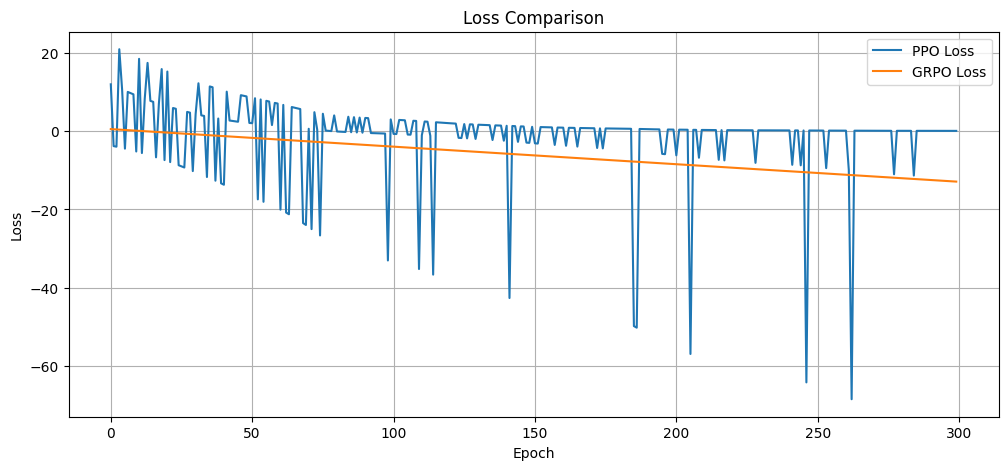


🔮 PPO Final Probabilities:
     cream: 0.9174
    hockey: 0.0620
    donkey: 0.0205

🔮 GRPO Final Probabilities:
     cream: 0.3976
    hockey: 0.6024
    donkey: 0.0000


In [2]:
# === GRPO vs PPO for 'I like ice ___' ===
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup
completions = ["cream", "hockey", "donkey"]
rewards = torch.tensor([10.0, 5.0, -10.0])
vocab_size = len(completions)

# Simple Model (Shared for PPO and GRPO)
class SimplePolicy(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(1, vocab_size)

    def forward(self):
        dummy_input = torch.tensor([[1.0]])  # fixed state
        logits = self.fc(dummy_input)
        probs = torch.softmax(logits, dim=-1)
        return probs.squeeze()

# PPO Training
def train_ppo(policy, optimizer, rewards):
    loss_history = []
    for epoch in range(300):
        probs = policy()
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        reward = rewards[action]

        baseline = torch.sum(probs * rewards)  # expected reward
        advantage = reward - baseline.detach()

        log_prob = torch.log(probs[action])
        loss = -log_prob * advantage

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
    return loss_history, policy()

# GRPO Training
def train_grpo(policy, optimizer, rewards):
    loss_history = []
    for epoch in range(300):
        probs = policy()
        dist = torch.distributions.Categorical(probs)

        # Standardize rewards (group advantage)
        adv = (rewards - rewards.mean()) / (rewards.std() + 1e-8)
        log_probs = torch.log(probs)
        loss = -torch.sum(adv * log_probs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
    return loss_history, policy()

# Initialize policies
ppo_policy = SimplePolicy()
grpo_policy = SimplePolicy()
ppo_opt = optim.Adam(ppo_policy.parameters(), lr=0.01)
grpo_opt = optim.Adam(grpo_policy.parameters(), lr=0.01)

ppo_loss, ppo_final = train_ppo(ppo_policy, ppo_opt, rewards)
grpo_loss, grpo_final = train_grpo(grpo_policy, grpo_opt, rewards)

# === Visualization ===
epochs = list(range(300))
plt.figure(figsize=(12, 5))
plt.plot(epochs, ppo_loss, label='PPO Loss')
plt.plot(epochs, grpo_loss, label='GRPO Loss')
plt.title("Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# === Final Learned Policies ===
def print_probs(label, probs):
    print(f"\n🔮 {label} Final Probabilities:")
    for word, p in zip(completions, probs):
        print(f"{word:>10}: {p.item():.4f}")

print_probs("PPO", ppo_final)
print_probs("GRPO", grpo_final)


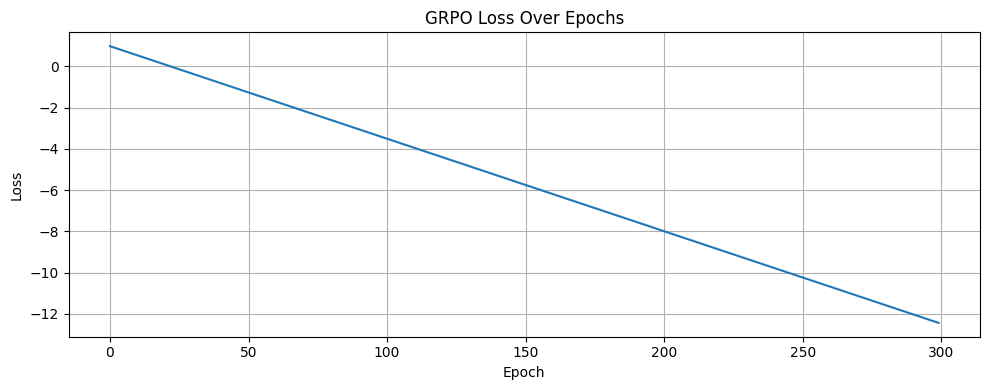


🎯 Final Learned Policy:
   cream: 0.4264
  hockey: 0.5736
  donkey: 0.0000


In [3]:
# === Standalone GRPO Example: 'I like ice ___' ===
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# === Setup ===
completions = ["cream", "hockey", "donkey"]
rewards = torch.tensor([10.0, 5.0, -10.0])
vocab_size = len(completions)

# === Simple Policy Model ===
class GRPOPolicy(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(1, vocab_size)

    def forward(self):
        dummy_input = torch.tensor([[1.0]])  # fixed prompt 'I like ice'
        logits = self.fc(dummy_input)
        probs = torch.softmax(logits, dim=-1)
        return probs.squeeze()

# === GRPO Training ===
def train_grpo(policy, optimizer, rewards, epochs=300):
    loss_history = []
    for epoch in range(epochs):
        probs = policy()
        log_probs = torch.log(probs + 1e-8)  # Avoid log(0)

        # Compute standardized group advantage
        adv = (rewards - rewards.mean()) / (rewards.std() + 1e-8)
        loss = -torch.sum(adv * log_probs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
    return loss_history, policy()

# === Initialize Model ===
model = GRPOPolicy()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# === Train ===
losses, final_probs = train_grpo(model, optimizer, rewards)

# === Plot Loss ===
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title("GRPO Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Print Final Probabilities ===
print("\n🎯 Final Learned Policy:")
for word, prob in zip(completions, final_probs):
    print(f"{word:>8}: {prob.item():.4f}")



--- Epoch 0 ---
[Corpus Frequency Counts] {'cream': 3, 'hockey': 2, 'donkey': 1}
[Raw Rewards] [3.0, 2.0, 1.0]
[Mean Reward] 2.0000, [Std Dev] 1.0000
[Standardized Advantages] [1.0, 0.0, -1.0]
[Logits] [1.4231412410736084, 0.8328970670700073, 1.0749906301498413]
[Probabilities] [0.44244176149368286, 0.24519766867160797, 0.31236058473587036]
[Log Probabilities] [-0.8154464364051819, -1.4056905508041382, -1.1635971069335938]
[Loss] -0.3482

--- Epoch 1 ---
[Corpus Frequency Counts] {'cream': 3, 'hockey': 2, 'donkey': 1}
[Raw Rewards] [3.0, 2.0, 1.0]
[Mean Reward] 2.0000, [Std Dev] 1.0000
[Standardized Advantages] [1.0, 0.0, -1.0]
[Logits] [1.443141222000122, 0.8328970670700073, 1.0549906492233276]
[Probabilities] [0.45014050602912903, 0.2445245385169983, 0.3053348958492279]
[Log Probabilities] [-0.798195481300354, -1.4084395170211792, -1.1863460540771484]
[Loss] -0.3882

--- Epoch 2 ---
[Corpus Frequency Counts] {'cream': 3, 'hockey': 2, 'donkey': 1}
[Raw Rewards] [3.0, 2.0, 1.0]
[Mean 

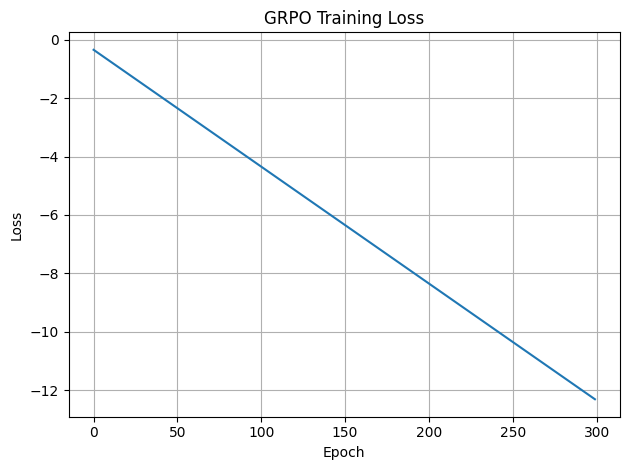


📊 Final Learned Completion Probabilities (from corpus frequency):
   cream: 1.0000
  hockey: 0.0000
  donkey: 0.0000


In [5]:
# === GRPO from Corpus: I like ice ___ (No Explicit Reward) ===
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt

# === 1. Toy Corpus ===
corpus = [
    "I like ice cream",
    "I like ice cream",
    "I like ice cream",
    "I like ice hockey",
    "I like ice hockey",
    "I like ice donkey",
]

# === 2. Completion Options ===
completions = ["cream", "hockey", "donkey"]
vocab_size = len(completions)
completion_to_index = {word: i for i, word in enumerate(completions)}

# === 3. Create Frequency-Based Rewards from Corpus ===
def infer_rewards_from_corpus(corpus, completions):
    counts = {c: 0 for c in completions}
    for line in corpus:
        last_word = line.strip().split()[-1].lower()
        if last_word in counts:
            counts[last_word] += 1
    rewards = torch.tensor([counts[c] for c in completions], dtype=torch.float32)
    print(f"[Corpus Frequency Counts] {counts}")
    return rewards

# === 4. Simple GRPO Model ===
class GRPOPolicy(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(1, vocab_size)

    def forward(self):
        dummy_input = torch.tensor([[1.0]])
        logits = self.fc(dummy_input)
        probs = torch.softmax(logits, dim=-1)
        return probs.squeeze(), logits.squeeze()

# === 5. GRPO Training Function ===
def train_grpo_from_inferred_reward(policy, optimizer, corpus, completions, epochs=300):
    loss_history = []
    for epoch in range(epochs):
        print(f"\n--- Epoch {epoch} ---")

        # Step 1: Infer rewards from corpus
        raw_rewards = infer_rewards_from_corpus(corpus, completions)
        mean = raw_rewards.mean().item()
        std = raw_rewards.std().item()
        rewards = (raw_rewards - mean) / (std + 1e-8)

        print(f"[Raw Rewards] {raw_rewards.tolist()}")
        print(f"[Mean Reward] {mean:.4f}, [Std Dev] {std:.4f}")
        print(f"[Standardized Advantages] {rewards.tolist()}")

        # Step 2: Get policy probabilities and logits
        probs, logits = policy()
        log_probs = torch.log(probs + 1e-8)

        print(f"[Logits] {logits.tolist()}")
        print(f"[Probabilities] {probs.tolist()}")
        print(f"[Log Probabilities] {log_probs.tolist()}")

        # Step 3: Compute GRPO loss
        loss = -torch.sum(rewards * log_probs)

        print(f"[Loss] {loss.item():.4f}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
    return loss_history, policy()[0]

# === 6. Train the Model ===
model = GRPOPolicy()
optimizer = optim.Adam(model.parameters(), lr=0.01)
losses, final_probs = train_grpo_from_inferred_reward(model, optimizer, corpus, completions)

# === 7. Visualize ===
plt.plot(losses)
plt.title("GRPO Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 8. Show Learned Probabilities ===
print("\n📊 Final Learned Completion Probabilities (from corpus frequency):")
for word, prob in zip(completions, final_probs):
    print(f"{word:>8}: {prob.item():.4f}")
